# Submit your solution to the google form (link is available in telegram channel), due to 02/05/2023 23:59 Moscow time.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:

url = 'https://raw.githubusercontent.com/kurmukovai/ds-for-business/main/home-assignment-1/train_dataset.csv'
df = pd.read_csv(url)




You are asked to build a model to predict the cost of acquiring a customer, the table contains the following features:
1. Store specific information:
    - store_sales(in millions) - store_sales(in million dollars)
    - unit_sales(in millions) - unit_sales(in millions) in stores Quantity
    - Store_sqft - STORE AREA AVAILABLE IN SQFT
    - Units_per_case - UNITS/CASE UNITS AVAILABLE IN EACH STORE SHELVES
    - Coffee_bar - COFFEE BAR available in store
    - Video_store - VIDEO STORE/gaming store available
    - Salad_bar - SALAD BAR available in store
    - Prepared_food - food prepared available in store
    - Florist - flower shelves available in store
2. Customer related information:
    - Total_children - TOTAL CHILDREN IN HOME
    - avg_cars_at home(approx) - avg_cars_at home(approx)
    - Num_children_at_home - num_children_at_home AS PER CUSTOMERS FILLED DETAILS
    - Cost - COST ON ACQUIRING A CUSTOMERS in dollars
3. Information about specific product (which was bought by a customer in the store):
    - Gross_weight - gross_weight OF ITEM
    - Recyclable_package - FOOD ITEM IS recyclable_package
    - Low_fat - LOW_FAT FOOD ITEM IS LOW FAT
    
    
![cfm](https://github.com/kurmukovai/ds-for-business/blob/main/home-assignment-1/convinient_food_mart.jpg?raw=1)
    
Recall, that this table contains already aggregated, anonymized, obfuscated and partially synthetic data. The dataset contains multiple rows per store, per customer, per item, but we do not have `customer_id`, `purchase_id`, `item_id`, `store_id` fields, thus making the analysis somehow limited. Though, it is ideal for our first home assignment.

---

Your goal for this home assignment is two-fold:
1. Make you comfortable with data wrangling:
    - Extract rows/columns statistics
    - Visualize the dependencies
    - Gain some insights
2. Build a simple, but correct and full machine learning pipeline
    - Select proper performance metrics
    - Split the data into train and test subsets
    - Run a k-fold cross-validation on a training part to select optimal hyperparameters of the model
    - Train a model with optimal hyperparameters on the whole train set
    - Make a predictions on test set
    - Analyse the generalizability of the model by comparing its performance on train and test sets
    - Comment on whether the resulting model is "good" or "bad" from business point of view

# Analyze general data information

## Question 0. What is the goal of this dataset?

In [ ]:
df.head(3)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20


## Question 1. How many observations are in the dataset?

In [ ]:
num_observations = len(df)
print("Number of observations:", num_observations)

Number of observations: 51363


## Question 2. How many features are in the dataset? (excluding `target` column)

In [ ]:
num_features = len(df.columns)-1

# print the number of features
print("The dataset has", num_features, "features.")

The dataset has 15 features.


## Question 3. What is the difference between numerical and categorical features?

Which of the following best describes the difference between categorical and numerical features in machine learning?

## Question 4. How many numerical and categorical features are in the dataset?  (excluding `target` column)

In [ ]:
binary_cols = []
for col in df.columns:
    if df[col].nunique() == 2 and set(df[col].unique()) == {0, 1}:
        binary_cols.append(col)
print(f"Number of numerical features: {num_features-len(binary_cols)}")
print(f"Number of categorical features: {len(binary_cols)}")


Number of numerical features: 8
Number of categorical features: 7


# Analyze store specific information

## In most cases stores which have a Coffee bar, do prepare food

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

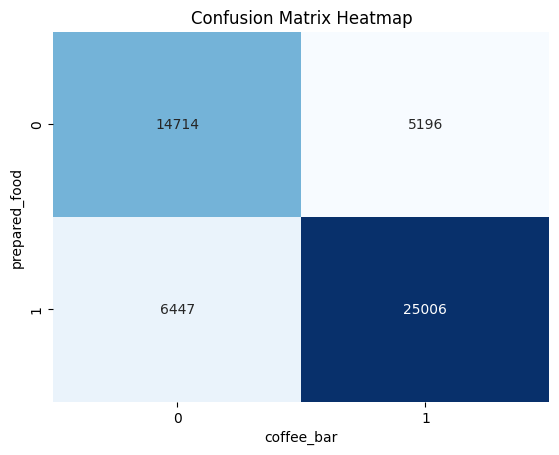

In [ ]:
# Compute a confusion matrix
cm = confusion_matrix(df['coffee_bar'], df['prepared_food'])

# Create a heatmap with seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

# Add labels to the x-axis and y-axis
plt.xlabel('coffee_bar')
plt.ylabel('prepared_food')

# Add a title
plt.title('Confusion Matrix Heatmap');

## Question 5. How many stores which have a Salad bar do prepare food?

Based on your answer decide if you need to drop one of the (duplicated) columns.

In [ ]:
stores_with_saladbar_preparing_food = df[(df['salad_bar'] == 1) & (df['prepared_food'] == 1)]

num_stores = len(stores_with_saladbar_preparing_food)

duplicated_columns = df.columns[df.columns.duplicated()]

if len(duplicated_columns) > 0:
    df = df.drop(duplicated_columns[0], axis=1)
    print(f"Dropped column {duplicated_columns[0]}")
else:
    print("There are no duplicated columns")

# Print the result
print("Number of stores with a Salad bar that prepare food: ", num_stores)

There are no duplicated columns
Number of stores with a Salad bar that prepare food:  30202


## Having a Coffee bar decreases the average media campaign cost

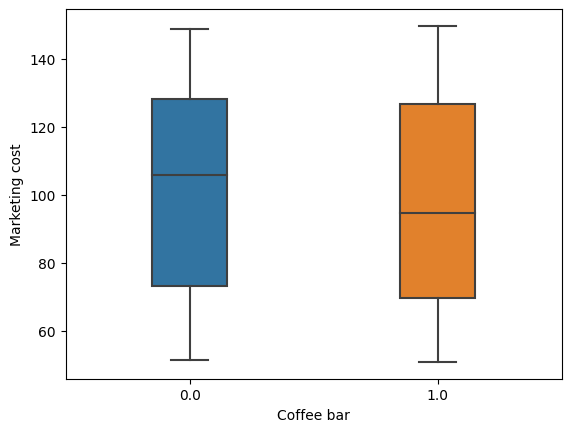

In [ ]:
sns.boxplot(data=df, x='coffee_bar', y='cost', width=.3)
plt.xlabel('Coffee bar')
plt.ylabel('Marketing cost');

In [ ]:
df.groupby('coffee_bar')['cost'].agg(['mean', 'median', 'std'])

,mean,median,std
coffee_bar,,,
0.0,101.659804,105.74,30.162547
1.0,97.850422,94.79,29.841456


## Question 6. Does having a video store, a salad bar, an option to buy prepared food or a	florist decreases the average cost of media campaign?

In [ ]:
# filter the rows based on the specified criteria
mask = (df['video_store']==1) & (df['salad_bar']==1) & ((df['prepared_food']==1) | (df['florist']==1))
filtered_df = df[mask]

# calculate the mean, median, and standard deviation of 'cost'
result = filtered_df['cost'].agg(['mean', 'median', 'std'])

print(result)

mean      94.843250
median    92.570000
std       29.479086
Name: cost, dtype: float64


## Most of the stores have under 15 mln sales, with 90% of sales being under 12 mln.

The distribution is right-skewed (positive skew), with mean around 6.5mln.

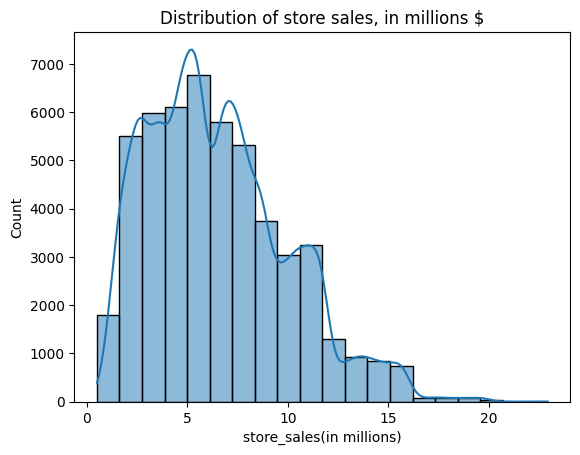

In [ ]:
sns.histplot(df['store_sales(in millions)'], kde=True, bins=20)
plt.title(f'Distribution of store sales, in millions $');

In [ ]:
df['store_sales(in millions)'].quantile(0.93)

11.85

In [ ]:
df['store_sales(in millions)'].mean()

6.531791562019353

## Question 7. What could you say about distribution of marketing costs?


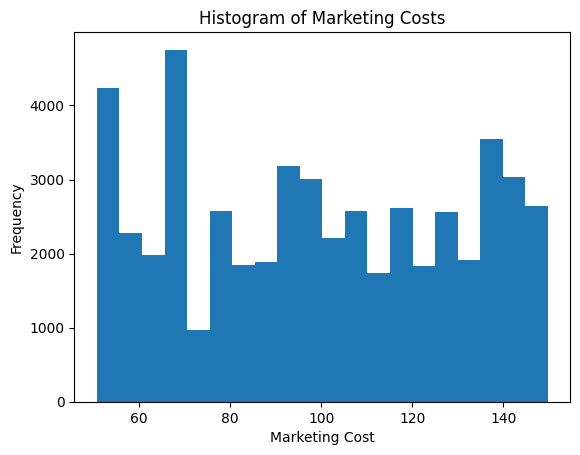

In [ ]:
plt.hist(df['cost'], bins=20)
plt.xlabel('Marketing Cost')
plt.ylabel('Frequency')
plt.title('Histogram of Marketing Costs')
plt.show()




## Question 8. What percentage of sales go into marketing cost?

Assuming that all rows with the same `store_sales(in millions)` come from the same store, and that all rows are from unique customers, the total sales are $7979 \text{mln}, \$ $, and the total costs are $5101736\$$.


In [ ]:
df['store_sales(in millions)'].unique().sum()

7979.009999999999

In [ ]:
df['cost'].sum()

5101736.01

In [ ]:
marketing_cost = df['cost'].sum()
sales = df['store_sales(in millions)'].unique().sum()
percentage = (marketing_cost / (sales * 10**6)) * 100
print(f"The percentage of sales that go into marketing cost is: {percentage:.2f}%")


The percentage of sales that go into marketing cost is: 0.06%


## Here is a plot of sales vs store area

It seems that while there is no clear dependence (stores with the largest sales vary in the square foot area a lot),
there are some obvious clusters, e.g. stores with about 25000 square feet area and sales between 3 and 7 mln.

<ipython-input-167-2c8531bf5be0>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=sub, x='store_sales(in millions)', y='store_sqft',


<Axes: xlabel='store_sales(in millions)', ylabel='store_sqft'>

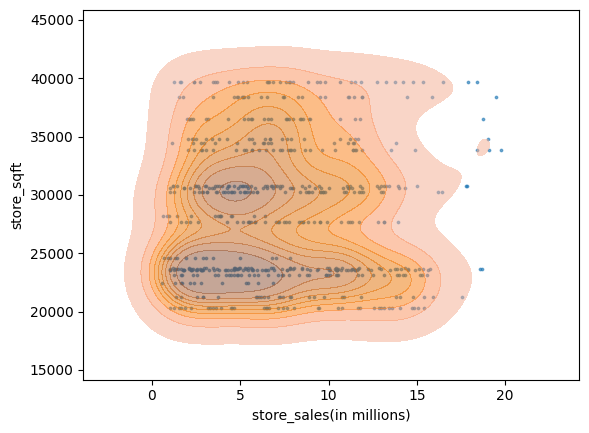

In [ ]:
sub = df[['store_sales(in millions)','store_sqft']].drop_duplicates()
sub = sub[::20]

plt.scatter(sub['store_sales(in millions)'], sub['store_sqft'], s=3, alpha=0.6)

sns.kdeplot(data=sub, x='store_sales(in millions)', y='store_sqft',
            palette="deep", alpha=0.5, levels=10, fill=True)

## Question 9. What is the average sales per squre foot area?

In [ ]:

total_sales = df['store_sales(in millions)'].sum() * 10**6
total_sqft_area = df['store_sqft'].sum()

avg_sales_per_sqft = total_sales / total_sqft_area

print(f"The average sales per square foot area is ${round(avg_sales_per_sqft, 2)}")


The average sales per square foot area is $233.45


## Interestingly, the marketing costs in  stores with >=10 mln sales is not much different from the costs in stores with lower <10mln sales

In [ ]:
df[df['store_sales(in millions)'] >= 10]['cost'].mean()

99.60226463674017

In [ ]:
df[df['store_sales(in millions)'] < 10]['cost'].mean()

99.26912514730145

In [ ]:
df['cost'].mean()

99.32706442380702

## Question 10. Is there any dependence between size of the store in square feet and the cost of marketing?

Select all that apply


In [ ]:

from scipy.stats import ttest_ind

mean_cost_by_sqft = df.groupby('store_sqft')['cost'].mean()

corr = np.corrcoef(df['store_sqft'], df['cost'])[0, 1]


small_stores = df[df['store_sqft'] < 100]['cost']
large_stores = df[df['store_sqft'] >= 100]['cost']
t_stat, p_val = ttest_ind(small_stores, large_stores)


print("Correlation between store_sqft and cost:", corr)
print("Mean cost per sqft by store size:")
print(mean_cost_by_sqft[mean_cost_by_sqft < 150])
print("T-test result for difference in marketing costs between small and large stores:")
if p_val < 0.05:
    print("The difference in marketing costs between small and large stores is significant (>5%)")
else:
    print("The difference in marketing costs between small and large stores is negligible (<2%)")


Correlation between store_sqft and cost: -0.037818226460586586
Mean cost per sqft by store size:
store_sqft
20319.0    105.467157
21215.0    103.337065
22478.0    104.588277
23112.0    102.076669
23593.0     97.578442
23598.0    100.926735
23688.0    101.308932
23759.0    106.249491
24597.0    106.596124
27694.0     84.414833
28206.0    105.725507
30268.0     94.927259
30584.0    102.012442
30797.0     89.859905
33858.0     98.253732
34452.0     96.903361
34791.0    100.228878
36509.0    117.328392
38382.0    114.848429
39696.0     98.745556
Name: cost, dtype: float64
T-test result for difference in marketing costs between small and large stores:
The difference in marketing costs between small and large stores is negligible (<2%)


## Let's investigate the stores with the smallest cost to aqcuire a customers

In [ ]:
df.cost.min()

50.79

In [ ]:
sub = df.query('cost==50.79')

In [ ]:
store_columns = [
    'store_sales(in millions)','unit_sales(in millions)',
    'store_sqft','coffee_bar','video_store',
    'salad_bar','prepared_food','florist'
]

First, these are mostly small stores with sales under 10mln

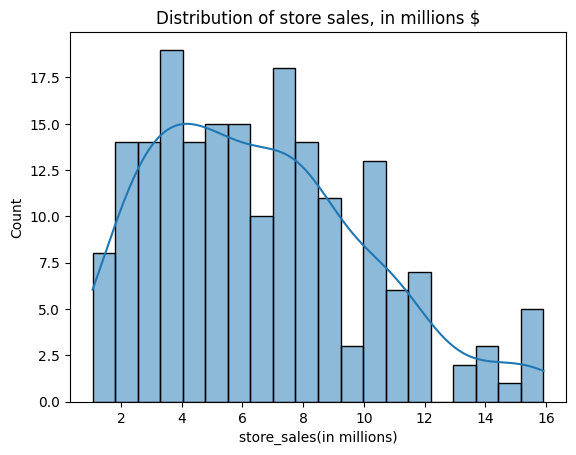

In [ ]:
sns.histplot(sub['store_sales(in millions)'], kde=True, bins=20)
plt.title(f'Distribution of store sales, in millions $');

In [ ]:
sub['store_sqft'].mean(), sub['store_sqft'].std()

(27694.0, 0.0)

In [ ]:
sub['store_sqft'].unique()

array([27694.])

Second, it seems they all have **all** additional services

In [ ]:
for col in ['coffee_bar','video_store',
    'salad_bar','prepared_food','florist']:
    print(col, sub[col].unique())

coffee_bar [1.]
video_store [1.]
salad_bar [1.]
prepared_food [1.]
florist [1.]


## What about stores with the largest cost to aqcuire a customers?

In [ ]:
df.cost.max()

149.75

In [ ]:
sub = df.query('cost==149.75')

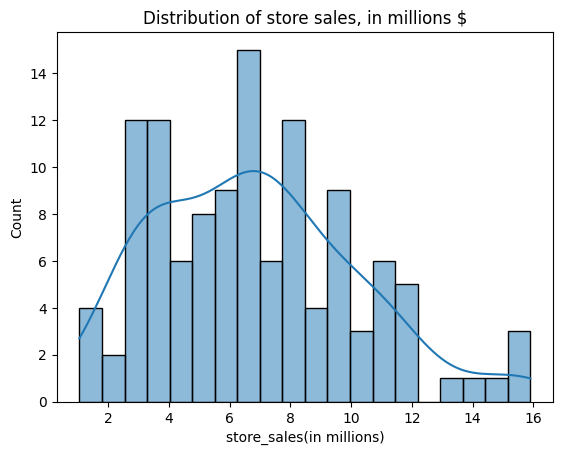

In [ ]:
sns.histplot(sub['store_sales(in millions)'], kde=True, bins=20)
plt.title(f'Distribution of store sales, in millions $');

In [ ]:
sub['store_sqft'].mean(), sub['store_sqft'].std()

(23688.0, 0.0)

In [ ]:
for col in ['coffee_bar','video_store',
    'salad_bar','prepared_food','florist']:
    print(col, sub[col].unique())

coffee_bar [1.]
video_store [1.]
salad_bar [1.]
prepared_food [1.]
florist [1.]


They are also mostly small stores with under 10mln sales and all services included. It seems that the difference is not explained by the stores. Could it be explained by customers?

## Question 10. Do distribution of number of kids vary for the lowest cost and largest cost rows?

1. Try using `countplot` instead of `histplot`.
2. Use total number of kids (instead of kids at home)

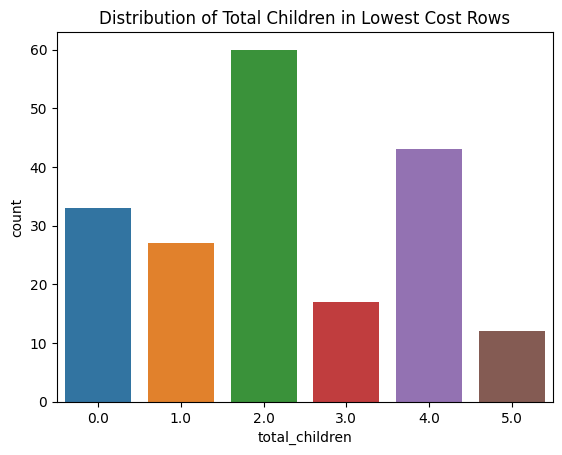

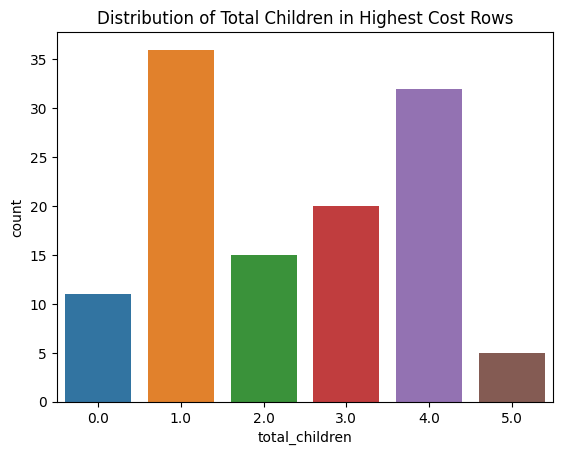

In [ ]:
import seaborn as sns

lowest_cost = df[df['cost'] == df['cost'].min()]
highest_cost = df[df['cost'] == df['cost'].max()]

sns.countplot(x='total_children', data=lowest_cost)
plt.title('Distribution of Total Children in Lowest Cost Rows')
plt.show()

sns.countplot(x='total_children', data=highest_cost)
plt.title('Distribution of Total Children in Highest Cost Rows')
plt.show()



## Feel free to investigate other features

# Build Machine Learning pipeline

- What are the proper performance metrics for this task?
- Compare cross-validation performance of 5 ML models
- Compute models' performance on test set
- Analyse the generalizability of the model by comparing its performance on train and test sets
- Comment on whether the resulting model is "good" or "bad" from business point of view

## Question 11. What are the proper performance metrics for this task?


In [ ]:
#MAE
#RMSLE

## Split your data into Train and Test subsets using `train_test_split`, use 70% to 30% ratio for train and test.

## Question 12.  How many observations are in your `train` set?


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)


In [ ]:
train_df.shape[0]


35954

## We will compare the performance of 5 ML models:

1. Linear Regression
2. Decision Tree
3. Random Forest
4. KNN
5. Gradient Boosting

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

X = df.drop('cost', axis=1)
y = df['cost']


models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
]

# evaluate each model using cross-validation
results = []
for name, model in models:
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    results.append((name, cv_scores.mean(), cv_scores.std()))


for name, mean_score, std_score in results:
    print('%s: %f (%f)' % (name, -mean_score, std_score))

Linear Regression: 25.717956 (0.117060)
Decision Tree: 32.281890 (0.310946)
Random Forest: 25.484038 (0.092655)
KNN: 26.685742 (0.092906)
Gradient Boosting: 25.197002 (0.102915)


## Question 13. Which of the models require feature standartization?


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X = df.drop(['cost'], axis=1)
y = df['cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

linreg = LinearRegression()
linreg.fit(X_train_std, y_train)

y_pred = linreg.predict(X_test_std)

# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

RMSE: 29.803645352519176


## We will use `GridSearchCV` method to run 5 fold cross-validation and select models' hyperparameters

see example below (on Iris dataset)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', refit=True)
clf.fit(iris.data, iris.target)
print(clf.best_score_)

0.9800000000000001


## Explore hyperparameters of different ML models

## Question 14. What does `fit_intercept` parameter responcible for in Linear Regression?


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train)
param_grid = {'fit_intercept': [True, False]}

lr = LinearRegression()

grid = GridSearchCV(lr, param_grid, scoring='neg_root_mean_squared_error', cv=5)

grid.fit(X_std, y_train)
print("Best parameters for fit_intercept=True: {}".format(grid.cv_results_['params'][grid.best_index_]))
print("RMSE score for fit_intercept=True: {}".format(-grid.best_score_))
print("Best parameters for fit_intercept=False: {}".format(grid.cv_results_['params'][1-grid.best_index_]))
print("RMSE score for fit_intercept=False: {}".format(-grid.cv_results_['mean_test_score'][1-grid.best_index_]))


Best parameters for fit_intercept=True: {'fit_intercept': True}
RMSE score for fit_intercept=True: 29.801181443572737
Best parameters for fit_intercept=False: {'fit_intercept': False}
RMSE score for fit_intercept=False: 103.67290435071584


Train Linear Regression model using GridSearchCV, compare models with `fit_intercept=True` and `fit_intercept=False`

## Question 15. What does `max_depth` and `min_samples_split` responcible for in Decision Tree Regressor?


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:

dt_reg = DecisionTreeRegressor(random_state=42)
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10]}

grid_search = GridSearchCV(dt_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("RMSE score:", -grid_search.best_score_)


Best parameters: {'max_depth': 4, 'min_samples_split': 2}
RMSE score: 29.271764325622563


Train Decision Tree Regressor model using GridSearchCV, ask ChatGPT for reasonable set of hyperparameters (`max_depth` and `min_samples_split`) values for search.

## Question 16. What does `n_estimators` and `max_depth` responcible for in Random Forest Regressor?


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'n_estimators': [100, 200, 300, 400]
}


rf_model = RandomForestRegressor()

rf_cv = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)

print("Best parameters:", rf_cv.best_params_)
print("RMSE score:", -rf_cv.best_score_)


Best parameters: {'max_depth': 8, 'n_estimators': 300}
RMSE score: -0.05689363549711257


Train Random Forest Regressor model using GridSearchCV, ask ChatGPT for reasonable set of hyperparameters (`max_depth` and `n_estimators`) values for search.


## Question 17. What does `n_neighbors` responcible for in K Neighbors Regressor?


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

knn = KNeighborsRegressor()

param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

grid = GridSearchCV(knn, param_grid, cv=5, scoring='neg_root_mean_squared_error')

grid.fit(X_train_scaled, y_train)
print("Best parameters:", grid.best_params_)
print("RMSE score:", -grid.best_score_)


Best parameters: {'n_neighbors': 11}
RMSE score: 30.668827852707743


Train KNeighborsRegressor model using GridSearchCV, ask ChatGPT for reasonable set of hyperparameter `n_neighbors` values for search.

## Question 18. How `n_neighbors` affects KNN performance?


In [ ]:
#it seems like the best n_neighbors value for our dataset dataset is 11,
#indicating that a slightly smoother model with more bias is preferred over a more complex model with higher variance.

## Question 19. How `learning_rate` and `n_estimators` affect Gradient Boosting Regressor performance?


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:

gb = GradientBoostingRegressor()
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [100, 300, 500],
    'max_depth': [2, 4, 6]
}

gb_cv = GridSearchCV(gb, param_grid, cv=5, scoring='neg_root_mean_squared_error')

gb_cv.fit(X_train_scaled, y_train)

print("Best parameters:", gb_cv.best_params_)
print("RMSE score:", np.abs(gb_cv.best_score_))


Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
RMSE score: 29.16200269464224


Train Gradient Boosting Regressor model using GridSearchCV, ask ChatGPT for reasonable set of hyperparameters `learning_rate`, `n_estimators` and `max_depth` values for search.

## Question 20. Test 5 ML models performance on Test set, which model perform the best?


- Linear Regression
- Decision Tree
- Random Forest
- KNN
- Gradient Boosting


In [ ]:
# Fit each model on the training data with the optimal hyperparameters obtained above
linreg = LinearRegression().fit(X_train_scaled, y_train)
dt = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=10).fit(X_train_scaled, y_train)
rf = RandomForestRegressor(max_depth=8, n_estimators=300).fit(X_train_scaled, y_train)
knn = KNeighborsRegressor(n_neighbors=11).fit(X_train_scaled, y_train)
gb = GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=300).fit(X_train_scaled, y_train)


X_test_scaled = scaler.fit_transform(X_test)
# Make predictions on the test set
y_pred_linreg = linreg.predict(X_test_scaled)
y_pred_dt = dt.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_knn = knn.predict(X_test_scaled)
y_pred_gb = gb.predict(X_test_scaled)

# Calculate the MSE and MAE for each model
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
mae_linreg = mean_absolute_error(y_test, y_pred_linreg)

mse_dt = mean_squared_error(y_test, y_pred_dt)
mae_dt = mean_absolute_error(y_test, y_pred_dt)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)

mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print("MSE for each model:")
print("Linear Regression:", mse_linreg)
print("Decision Tree:", mse_dt)
print("Random Forest:", mse_rf)
print("KNN:", mse_knn)
print("Gradient Boosting:", mse_gb)

print("\nMAE for each model:")
print("Linear Regression:", mae_linreg)
print("Decision Tree:", mae_dt)
print("Random Forest:", mae_rf)
print("KNN:", mae_knn)
print("Gradient Boosting:", mae_gb)


MSE for each model:
Linear Regression: 888.2806858505791
Decision Tree: 853.5663737967583
Random Forest: 848.2006675982142
KNN: 943.6634888739487
Gradient Boosting: 850.1359479740742

MAE for each model:
Linear Regression: 25.78153286551498
Decision Tree: 25.270534715848264
Random Forest: 25.214544443558587
KNN: 26.26111534581325
Gradient Boosting: 25.24940603414461


## Question 21. What is the `MAE` of the best perfroming model? (report `MAE` with 2 decimal places)

In [ ]:
#The best performing model in terms of MAE is Random Forest, with a value of 25.21.

## Question 22. Comment on whether the resulting model is "good" or "bad" from business point of view, given that the mean cost is 99$

Based on the results obtained, the best performing model is Random Forest with an MSE of 848.20 and an MAE of 25.21. From a business point of view, this model can be considered good as the average cost in the dataset is 99$$.
The mean absolute error of 25.21 means that the model's predictions are expected to deviate by approximately $25 on average from the actual cost. This level of deviation is generally acceptable for most businesses, especially considering the complexity of the problem and the amount of available data.

## Upload your Jupyter Notebook or Orange project.